# Sheet 10

## 1 Optimal Transport

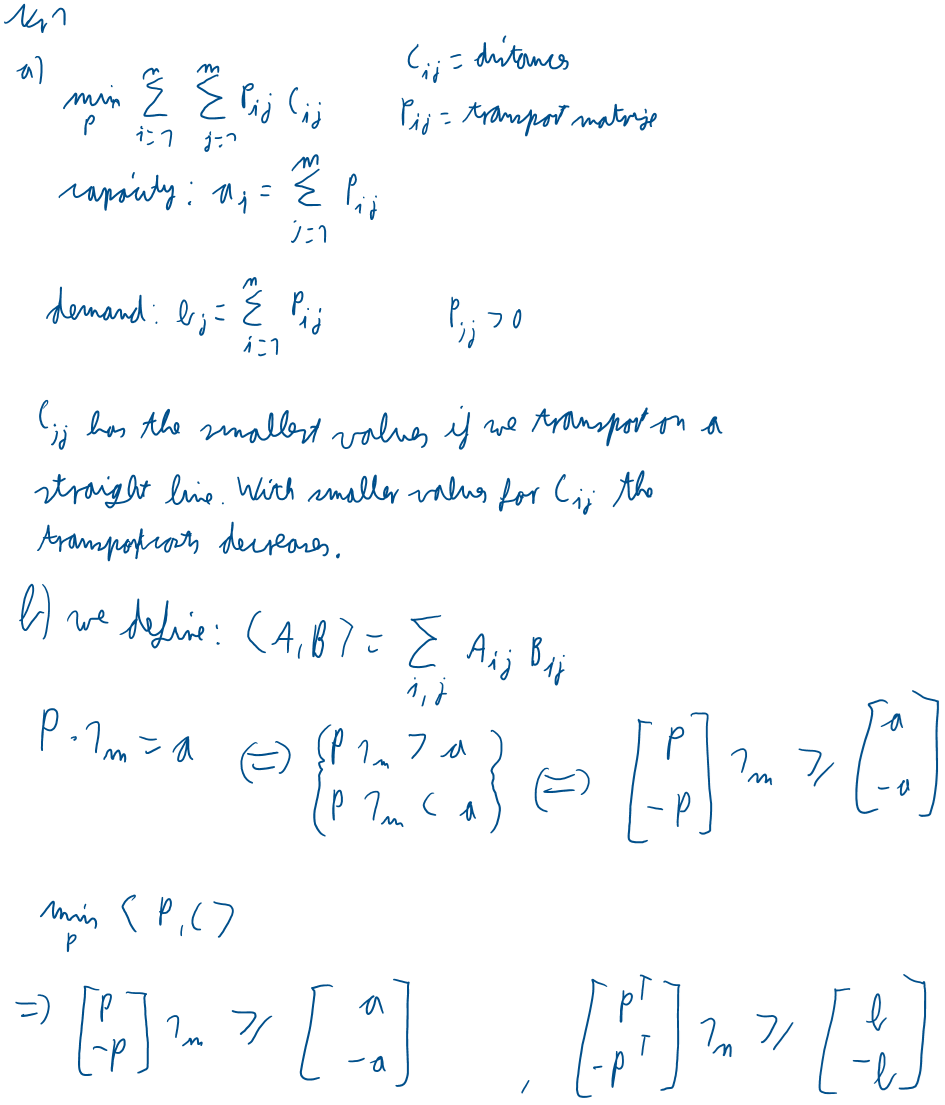

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

d = 5
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [26]:
# TODO: solve the OT problem as linear program

distances = np.zeros((num_sources, num_sinks))
for i in range(num_sources):
    for j in range(num_sinks):
        distances[i, j] = np.linalg.norm(coords_sources[i] - coords_sinks[j])

distances.shape

from scipy.optimize import linprog

c = distances.flatten()

A_eq = np.zeros((num_sources + num_sinks, num_sources * num_sinks))
b_eq = mass_sources.tolist() + mass_sinks.tolist()

for i in range(num_sources):
    for j in range(num_sinks):
        A_eq[i, i*num_sinks + j] = 1

for i in range(num_sinks):
    for j in range(num_sources):
        A_eq[num_sources + i, j*num_sinks + i] = 1

res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, None))

cost = c.T@res.x
print(f"Transport cost: {cost:.3f}")

Transport cost: 0.671


### d)

Let the intersecting routes transport $T_{ij}$ from $x_i \to y_j$ and $T_{kl}$ from $x_k \to y_l$. The total cost of these two routes is:
$$
C_{\text{intersect}} = T_{ij} \cdot \|x_i - y_j\| + T_{kl} \cdot \|x_k - y_l\|.
$$

Now, consider rerouting the transportation:
- Transport $T_{ij}$ from $x_i \to y_l$.
- Transport $T_{kl}$ from $x_k \to y_j$.

The new total cost is:
$$
C_{\text{reroute}} = T_{ij} \cdot \|x_i - y_l\| + T_{kl} \cdot \|x_k - y_j\|.
$$

Using the triangle inequality:
$$
\|x_i - y_j\| + \|x_k - y_l\| \geq \|x_i - y_l\| + \|x_k - y_j\|.
$$

Equality holds only if $x_i, y_j, x_k, y_l$ lie on a straight line in the order of transportation. Otherwise:
$$
C_{\text{intersect}} > C_{\text{reroute}}.
$$


Since rerouting reduces the cost, any transportation plan with intersecting routes is suboptimal. Therefore, optimal transportation plans do not have intersecting routes.


## 2 Flow matching for generative modeling

In [ ]:
import torch


def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x
    
base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.show()

In [ ]:
# define a model
from torchvision.ops import MLP
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 20000  # use fewer epochs if it takes too long
batch_size = 4096
losses = []
for epoch in tqdm(range(num_epochs)):
    x = torch.randn(batch_size, 2) * base_distribution_std
    y = generate_checkerboard_sample(num_samples=batch_size)

    # TODO: implement the training loop

In [23]:
# TODO: run inference with the trained model. 
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.

## 3 Adversarial attacks and AI safety

In [24]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [25]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [ ]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

# TODO: train a logistic regression probe on the train_acts and train_labels

In [ ]:
# TODO: optimize a perturbation on a single sample which is a lie

In [ ]:
# TODO: check whether this perturbation works on other samples too

In [33]:
# TODO: add the constraint that the perturbation should be small